#Synthetic Data

In [ ]:
import folium
import numpy as np
from scipy.integrate import simps
import logging
import random
import pandas as pd
# Constants
GRAVITY = 9.81  # m/s^2
DENSITY_WATER = 1000  # kg/m^3
DEFAULT_EFFICIENCY = 0.00005

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Functions
def calculate_flow_rate(pressure_data, area, efficiency=DEFAULT_EFFICIENCY):
    if len(pressure_data) == 0 or area <= 0:
        logging.warning("Invalid pressure data or area. Flow rate cannot be calculated.")
        return 0
    avg_pressure = np.mean(pressure_data)
    velocity = np.sqrt((2 * avg_pressure) / DENSITY_WATER)
    return area * velocity * efficiency

def adjust_flow_for_seismic(flow_rate, seismic_activity):
    if seismic_activity > 7.0:
        return flow_rate * 3
    elif seismic_activity > 5.0:
        return flow_rate * 2
    return flow_rate

def adjust_flow_for_temperature(flow_rate, temperature):
    if temperature > 10:
        return flow_rate * 2.5
    elif temperature > 5:
        return flow_rate * 2
    return flow_rate

def adjust_flow_for_barriers(flow_rate, proximity_factor):
    return flow_rate * (1 - proximity_factor)

def calculate_risk_radii(flow_rate, duration, slope_factor, barrier_factor):
    if flow_rate <= 0 or duration <= 0:
        logging.warning("Invalid flow rate or duration. Risk radii cannot be calculated.")
        return 0, 0, 0
    flooded_volume = flow_rate * duration
    flooded_area = flooded_volume * slope_factor * barrier_factor
    radius_red = np.sqrt(flooded_area / np.pi)
    radius_orange = radius_red * 1.5
    radius_yellow = radius_red * 2.0
    return radius_red, radius_orange, radius_yellow

def determine_region_params(latitude, longitude):
    regions = [
        {"lat_range": (29.0, 31.5), "lon_range": (78.0, 81.0), "slope_factor": 1.5, "barrier_factor": 0.8},
        {"lat_range": (30.5, 33.0), "lon_range": (76.0, 79.0), "slope_factor": 1.4, "barrier_factor": 0.9},
        {"lat_range": (32.0, 36.0), "lon_range": (76.0, 80.0), "slope_factor": 1.6, "barrier_factor": 0.7},
        {"lat_range": (27.0, 28.5), "lon_range": (88.0, 89.5), "slope_factor": 1.2, "barrier_factor": 0.8},
    ]
    for region in regions:
        if region["lat_range"][0] <= latitude <= region["lat_range"][1] and region["lon_range"][0] <= longitude <= region["lon_range"][1]:
            return region["slope_factor"], region["barrier_factor"]
    logging.warning(f"Unknown region for latitude {latitude}, longitude {longitude}. Using default parameters.")
    return 1.0, 1.0

def estimate_outlet_area(pressure, duration, efficiency=DEFAULT_EFFICIENCY):
    if len(pressure) < 2 or duration <= 0:
        logging.warning("Insufficient pressure data or invalid duration. Outlet area cannot be calculated.")
        return 1
    pressure_drop = max(pressure) - min(pressure)
    velocity = np.sqrt(2 * GRAVITY * (pressure_drop / DENSITY_WATER))
    flow_rate = simps(pressure, dx=duration / len(pressure))
    outlet_area = flow_rate / (velocity * efficiency)
    return max(outlet_area, 1)

def estimate_duration(pressure, time, threshold=10000):
    pressure = np.array(pressure)
    significant_points = np.where(pressure > threshold)[0]
    if len(significant_points) == 0:
        return 0
    start_time = time[significant_points[0]]
    end_time = time[significant_points[-1]]
    return end_time - start_time

# Function to generate synthetic data and save to CSV
def generate_synthetic_data(num_samples=1000):
    # Initialize lists to store the data
    data = []

    # Generate synthetic data
    for _ in range(num_samples):
        # Randomly sample values for the inputs
        latitude = random.uniform(-90, 90)  # Latitude (-90 to 90 degrees)
        longitude = random.uniform(-180, 180)  # Longitude (-180 to 180 degrees)
        altitude = random.uniform(0, 5000)  # Altitude (meters above sea level)
        slope_factor = random.uniform(1.0, 2.0)  # Slope factor
        barrier_factor = random.uniform(0.5, 1.5)  # Barrier factor (e.g., vegetation, walls)
        rainfall = random.uniform(0, 300)  # Rainfall (mm/day)
        seismic_activity = random.uniform(0, 10)  # Seismic activity (magnitude)
        temperature = random.uniform(-10, 30)  # Temperature (°C)
        proximity_factor = random.uniform(0, 1)  # Proximity to barriers (0 to 1)
        duration = random.uniform(5000, 10000)  # Duration (s)
        area = random.uniform(10, 50)  # Area (m^2)

        # Estimate outlet area and calculate flow rate
        flow_rate = calculate_flow_rate([random.randint(9000, 16000) for _ in range(6)], area)
        flow_rate = adjust_flow_for_seismic(flow_rate, seismic_activity)
        flow_rate = adjust_flow_for_temperature(flow_rate, temperature)
        flow_rate = adjust_flow_for_barriers(flow_rate, proximity_factor)

        # Calculate the radii
        red_radius, orange_radius, yellow_radius = calculate_risk_radii(flow_rate, duration, slope_factor, barrier_factor)

        # Append the data to the list
        data.append([latitude, longitude, altitude,flow_rate, duration, slope_factor, barrier_factor, red_radius, orange_radius, yellow_radius])

    # Create a DataFrame and save to CSV with the specified column names
    columns = ['latitude', 'longitude', 'altitude','flow_rate', 'duration', 'slope_factor', 'barrier_factor', 'red_radius', 'orange_radius', 'yellow_radius']
    df = pd.DataFrame(data, columns=columns)

    # Save to CSV
    df.to_csv('synthetic_flood_risk_data_true.csv', index=False)
    print("Synthetic data saved to 'synthetic_flood_risk_data_true.csv'.")

# Run the synthetic data generation
generate_synthetic_data()

Synthetic data saved to 'synthetic_flood_risk_data_true.csv'.


#Zone Prediction Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error , r2_score


# Load the synthetic data
df = pd.read_csv('/content/synthetic_flood_risk_data_true.csv')

# Features (input) and Target (output)
X = df[['altitude','flow_rate', 'duration', 'slope_factor', 'barrier_factor']]
y = df[['red_radius', 'orange_radius', 'yellow_radius']]

# Data Preprocessing: Standardizing the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardizing the input features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the Neural Network Model with adjusted architecture
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.4),  # Regularization to avoid overfitting
    Dense(3)  # Output layer for 3 radii: red, orange, yellow
])

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Train the model with early stopping and learning rate reduction
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                    verbose=1, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on test data
y_pred = model.predict(X_test)

# Calculate R² score for evaluation
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

model.save('flood_risk_model.keras')


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 107.7478 - mae: 8.4668 - val_loss: 68.0037 - val_mae: 6.6536 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 61.8922 - mae: 6.0916 - val_loss: 22.2819 - val_mae: 3.4870 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.9695 - mae: 4.0432 - val_loss: 9.1853 - val_mae: 2.4177 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.0168 - mae: 2.7771 - val_loss: 7.0039 - val_mae: 2.1135 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.2322 - mae: 2.6609 - val_loss: 6.3888 - val_mae: 2.0143 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8431 - mae: 2.4744 - val_loss: 5.8411 - val_mae: 1.9135 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.2921 - mae: 2.5814 - val_loss: 5.7726 - val_mae: 1.9230 - learning_rate: 0.0010
Epoch 8/100
20

#Risk_Map

In [ ]:
import folium
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Load the trained model
model = load_model('/content/flood_risk_model.keras')

# Pre-trained scaler (ensure to save and load the same scaler used during training)
scaler = StandardScaler()

# Example input for Lhonak Lake
latitude = 27.9151  # Latitude for Lhonak Lake
longitude = 88.1476  # Longitude for Lhonak Lake
region_name = "Lhonak Lake"
altitude = 5200  # Approximate altitude in meters
flow_rate = 1.2  # Arbitrary flow rate (cubic meters per second)
duration = 6  # Flood duration in hours
slope_factor = 3.1  # Slope factor (steepness)
barrier_factor = 1.1  # Barrier factor (resistance to flooding)

# Prepare features for prediction, removing 'latitude' and 'longitude'
features = np.array([[altitude, flow_rate, duration, slope_factor, barrier_factor]])
features_scaled = scaler.fit_transform(features)  # Use the same scaler as in training

# Predict radii for zones
predicted_radii = model.predict(features_scaled)
red_radius, orange_radius, yellow_radius = predicted_radii[0]

def visualize_risk_zones_inline(latitude, longitude, red_radius, orange_radius, yellow_radius, region_name, flow_rate):
    """
    Visualize risk zones on a map with color-coded circles and display it inline in Colab.
    """
    # Create a map centered on the lake
    base_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="OpenStreetMap")
    folium.Marker([latitude, longitude], popup=f"Region: {region_name}<br>Flow Rate: {flow_rate:.2f} m³/s").add_to(base_map)

    # Add yellow zone
    folium.Circle(
        location=[latitude, longitude],
        radius=yellow_radius * 1000,
        color='yellow',
        fill=True,
        fill_opacity=0.2,
        popup=f"Yellow Zone Radius: {yellow_radius:.2f} km"
    ).add_to(base_map)

    # Add orange zone
    folium.Circle(
        location=[latitude, longitude],
        radius=orange_radius * 1000,
        color='orange',
        fill=True,
        fill_opacity=0.3,
        popup=f"Orange Zone Radius: {orange_radius:.2f} km"
    ).add_to(base_map)

    # Add red zone
    folium.Circle(
        location=[latitude, longitude],
        radius=red_radius * 1000,
        color='red',
        fill=True,
        fill_opacity=0.4,
        popup=f"Red Zone Radius: {red_radius:.2f} km"
    ).add_to(base_map)

    # Display the map inline
    return base_map._repr_html_()

# Generate and display the map inline
from IPython.display import display, HTML

display(HTML(visualize_risk_zones_inline(latitude, longitude, red_radius, orange_radius, yellow_radius, region_name, flow_rate)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


#DEM Download
##using Google Earth Engine

In [ ]:
# Install required libraries
!pip install earthengine-api folium geopandas

# Authenticate and initialize Earth Engine
import ee
ee.Authenticate()
ee.Initialize(project = 'ee-kumargaurav4108')

# Define the region of interest (5 km x 5 km around South Lhonak Lake)
lake_coords = [88.19633, 27.91214]  # Longitude, Latitude
region = ee.Geometry.Point(lake_coords).buffer(2500).bounds()  # 5x5 km bounding box

# Function to export data
def export_to_drive(image, description, scale, region):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder='Flood_Simulation',  # Specify folder name here
        scale=scale,
        region=region.getInfo()['coordinates'],
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f"{description} export task started.")

# 1. Digital Elevation Model (DEM)
dem = ee.Image('USGS/SRTMGL1_003').clip(region)
export_to_drive(dem, 'DEM_5km', 30, region)

# 2. Land Cover Data
landcover = ee.Image('ESA/WorldCover/v100/2020').select('Map').clip(region)
export_to_drive(landcover, 'LandCover_5km', 10, region)

# 3. Hydrological Data
hydro = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence').clip(region)
export_to_drive(hydro, 'Hydro_5km', 30, region)

# 4. Meteorological Data (Precipitation)
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate('2023-01-01', '2023-01-31').mean().clip(region)
export_to_drive(precip, 'Precipitation_5km', 5000, region)
'''
# 5. Soil Data
soil = ee.Image('ISRIC/SoilGrids/250m/texture').select('clay').clip(region)
export_to_drive(soil, 'Soil_5km', 250, region)
'''
# 6. Infrastructure Data
#The asset 'CSP/HM/GlobalHumanModification' is not an image, it's an ImageCollection.
# So, you need to use ee.ImageCollection to load it and then select an image from the collection.
infra = ee.ImageCollection('CSP/HM/GlobalHumanModification').first().clip(region)  # Selecting the first image from the collection
export_to_drive(infra, 'Infrastructure_5km', 100, region)
'''
# 7. Historical Flood Data
flood = ee.ImageCollection('JRC/GSW1_3/MonthlyHistory').filterDate('2023-01-01', '2023-01-31').mean().clip(region)
export_to_drive(flood, 'HistoricalFlood_5km', 30, region)
'''
print("All tasks have been submitted to Google Drive.")

DEM_5km export task started.
LandCover_5km export task started.


/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for JRC/GSW1_3/GlobalSurfaceWater! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_3_GlobalSurfaceWater

  warnings.warn(warning, category=DeprecationWarning)


Hydro_5km export task started.
Precipitation_5km export task started.
Infrastructure_5km export task started.
All tasks have been submitted to Google Drive.


#Flood Impact Generation

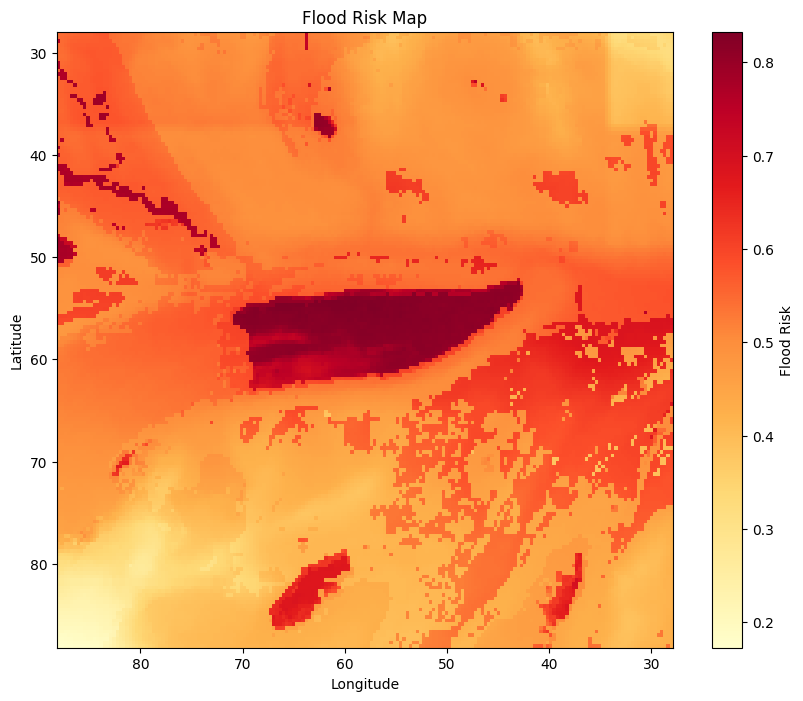

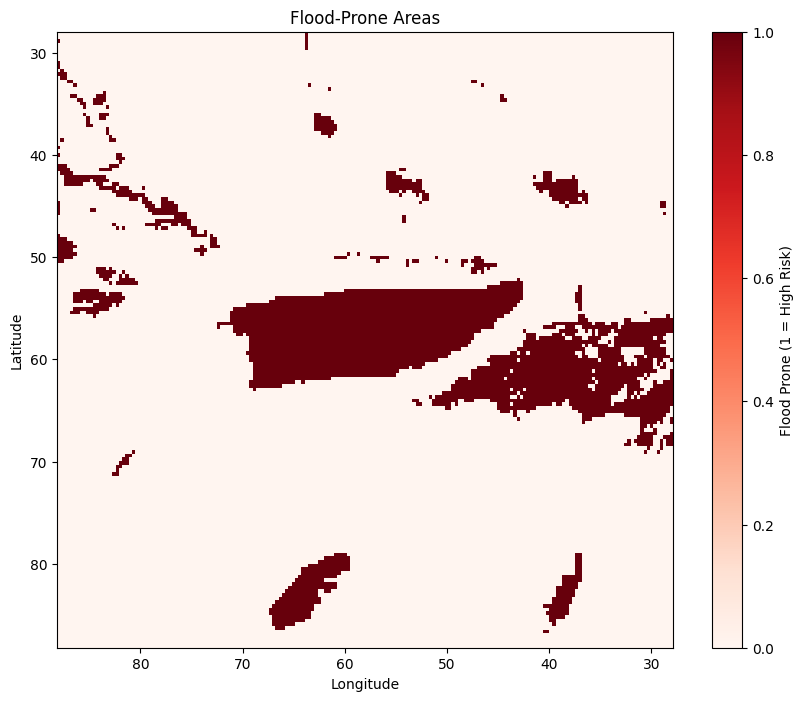

In [ ]:
!pip install rasterio numpy matplotlib
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling
# Paths to GeoTIFF files
dem_path = '/content/drive/MyDrive/Flood_Simulation/DEM_5km.tif'
landcover_path = '/content/drive/MyDrive/Flood_Simulation/LandCover_5km.tif'
hydro_path = '/content/drive/MyDrive/Flood_Simulation/Hydro_5km.tif'
precip_path = '/content/drive/MyDrive/Flood_Simulation/Precipitation_5km.tif'
infra_path = '/content/drive/MyDrive/Flood_Simulation/Infrastructure_5km.tif'

# Load GeoTIFF data
def load_data(filepath, reference=None):
    with rasterio.open(filepath) as src:
        data = src.read(1)  # Read the first band
        transform = src.transform
        crs = src.crs
        if reference:  # Resample to match reference
            data = src.read(1, out_shape=(reference.height, reference.width),
                            resampling=Resampling.bilinear)
            transform = reference.transform
    return data, transform, crs

# Open the DEM as the reference for resampling
with rasterio.open(dem_path) as ref_src:
    reference = ref_src  # Keep the DEM as reference

# Load and resample all datasets
dem_data, dem_transform, dem_crs = load_data(dem_path, reference)
landcover_data, _, _ = load_data(landcover_path, reference)
hydro_data, _, _ = load_data(hydro_path, reference)
precip_data, _, _ = load_data(precip_path, reference)
infra_data, _, _ = load_data(infra_path, reference)

# Normalize data for analysis
def normalize(data):
    valid = data[data > 0]
    if len(valid) > 0:  # Ensure valid data exists
        return (data - valid.min()) / (valid.max() - valid.min())
    else:
        return data

dem_normalized = normalize(dem_data)
landcover_normalized = normalize(landcover_data)
hydro_normalized = normalize(hydro_data)
precip_normalized = normalize(precip_data)
infra_normalized = normalize(infra_data)

# Combine datasets to identify flood-prone areas
# Adjust weights as needed for your specific analysis
weights = {
    'dem': 0.4,  # Topography contributes 40%
    'landcover': 0.2,  # Land cover contributes 20%
    'hydro': 0.2,  # Hydrology contributes 20%
    'precip': 0.1,  # Precipitation contributes 10%
    'infra': 0.1,  # Infrastructure contributes 10%
}

flood_risk = (
    weights['dem'] * (1 - dem_normalized) +  # Low elevation = higher risk
    weights['landcover'] * landcover_normalized +
    weights['hydro'] * hydro_normalized +
    weights['precip'] * precip_normalized +
    weights['infra'] * (1 - infra_normalized)  # Less human modification = higher risk
)

# Threshold flood risk for visualization
flood_threshold = 0.6  # Adjust as needed
flood_prone_areas = flood_risk > flood_threshold

# Plot the flood risk map
plt.figure(figsize=(10, 8))
plt.title('Flood Risk Map')
plt.imshow(flood_risk, cmap='YlOrRd', extent=rasterio.transform.array_bounds(reference.height, reference.width, reference.transform))
plt.colorbar(label='Flood Risk')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot flood-prone areas
plt.figure(figsize=(10, 8))
plt.title('Flood-Prone Areas')
plt.imshow(flood_prone_areas, cmap='Reds', extent=rasterio.transform.array_bounds(reference.height, reference.width, reference.transform))
plt.colorbar(label='Flood Prone (1 = High Risk)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#Flood Impact Map

In [ ]:
!pip install rasterio numpy matplotlib folium
import folium
import numpy as np
import rasterio
from rasterio.enums import Resampling
from shapely.geometry import shape
import geopandas as gpd
import rasterio.features

# Paths to GeoTIFF files
dem_path = '/content/drive/MyDrive/Flood_Simulation/DEM_5km.tif'
landcover_path = '/content/drive/MyDrive/Flood_Simulation/LandCover_5km.tif'
hydro_path = '/content/drive/MyDrive/Flood_Simulation/Hydro_5km.tif'
precip_path = '/content/drive/MyDrive/Flood_Simulation/Precipitation_5km.tif'
infra_path = '/content/drive/MyDrive/Flood_Simulation/Infrastructure_5km.tif'

# Load and normalize datasets
def load_data(filepath, reference=None):
    with rasterio.open(filepath) as src:
        data = src.read(1)
        if reference:  # Resample to match reference
            data = src.read(1, out_shape=(reference.height, reference.width), resampling=Resampling.bilinear)
    return data

# Open DEM as the reference for resampling
with rasterio.open(dem_path) as ref_src:
    reference = ref_src

# Load and resample all datasets
dem_data = load_data(dem_path, reference)
landcover_data = load_data(landcover_path, reference)
hydro_data = load_data(hydro_path, reference)
precip_data = load_data(precip_path, reference)
infra_data = load_data(infra_path, reference)

# Normalize datasets
def normalize(data):
    valid = data[data > 0]
    return (data - valid.min()) / (valid.max() - valid.min()) if len(valid) > 0 else data

dem_normalized = normalize(dem_data)
landcover_normalized = normalize(landcover_data)
hydro_normalized = normalize(hydro_data)
precip_normalized = normalize(precip_data)
infra_normalized = normalize(infra_data)

# Combine datasets into a composite flood risk layer
weights = {
    'dem': 0.4,  # Elevation contributes 40%
    'landcover': 0.2,  # Land cover contributes 20%
    'hydro': 0.2,  # Hydrology contributes 20%
    'precip': 0.1,  # Precipitation contributes 10%
    'infra': 0.1,  # Infrastructure contributes 10%
}

composite_risk = (
    weights['dem'] * (1 - dem_normalized) +  # Lower elevation = higher risk
    weights['landcover'] * landcover_normalized +
    weights['hydro'] * hydro_normalized +
    weights['precip'] * precip_normalized +
    weights['infra'] * (1 - infra_normalized)  # Less human modification = higher risk
)

# Generate flood thresholds for simulation
flood_threshold = 0.6  # Threshold to define flood-prone areas
flood_mask = composite_risk >= flood_threshold  # Flood-prone areas
non_flood_mask = ~flood_mask  # Non-flooded areas

# Create a GeoDataFrame for flood-prone areas
with rasterio.open(dem_path) as src:
    flood_geometries = [
        shape(geom) for geom, val in rasterio.features.shapes(flood_mask.astype(np.uint8), transform=src.transform) if val == 1
    ]
    non_flood_geometries = [
        shape(geom) for geom, val in rasterio.features.shapes(non_flood_mask.astype(np.uint8), transform=src.transform) if val == 1
    ]

flood_gdf = gpd.GeoDataFrame({'geometry': flood_geometries}, crs=src.crs)
non_flood_gdf = gpd.GeoDataFrame({'geometry': non_flood_geometries}, crs=src.crs)

# Initialize Folium map
flood_map = folium.Map(location=[27.91214, 88.19633], zoom_start=13)

# Add flood-prone areas in red
folium.GeoJson(
    flood_gdf.to_json(),
    style_function=lambda x: {
        "fillColor": "red",
        "color": "red",
        "weight": 1,
        "fillOpacity": 0.7,
    },
    name="Flood-Prone Areas (Red)"
).add_to(flood_map)

# Add non-flooded areas in blue
folium.GeoJson(
    non_flood_gdf.to_json(),
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.3,
    },
    name="Non-Flooded Areas (Blue)"
).add_to(flood_map)
lake_coords = (88.19633, 27.91214)
# Add Layer Control
folium.LayerControl().add_to(flood_map)
# Assuming lake_coords contains the epicenter coordinates
lake_coords = (88.19633, 27.91214)  # Assuming longitude, latitude

folium.Marker(
    location=[lake_coords[1], lake_coords[0]],  # Latitude, longitude for Folium
    popup="Lhonak lake",  # Text that pops up on click
    icon=folium.Icon(color="red", icon="info-sign")  # Red icon with info sign
).add_to(flood_map)
# Save and display the map
flood_map.save("Flood_Simulation_Map_Red_Blue_marked.html")
flood_map


#Flood Path Simulation

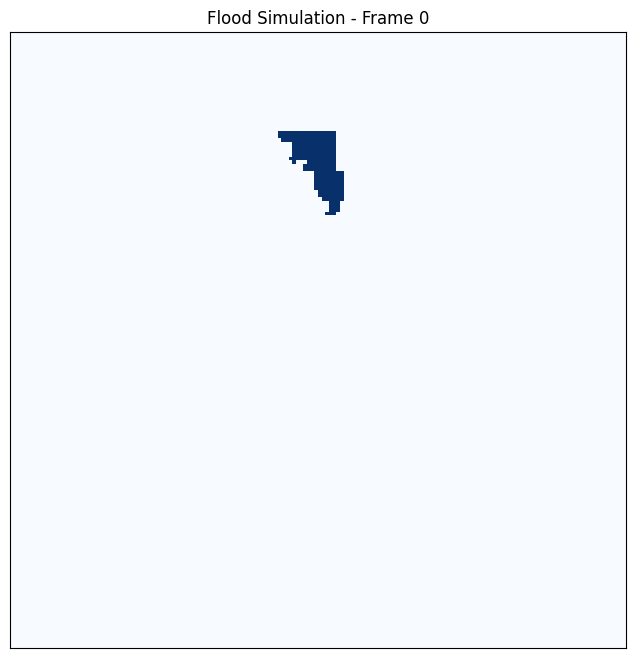

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import rasterio
from rasterio.transform import from_origin
from IPython.display import HTML

# Load DEM data
dem_path = '/content/drive/MyDrive/GEE_exports/South_Lhonak_Square_DEM.tif'  # Update with your DEM path

# Read the DEM data
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    dem_transform = src.transform  # Transformation data to map pixel coordinates to geographic coordinates

# Function to convert geographic coordinates (lat, lon) to pixel coordinates (row, col)
def geo_to_pixel(lat, lon, transform):
    """Convert geographic coordinates to pixel coordinates"""
    x, y = transform * (lon, lat)  # Transform to pixel space
    row, col = int(y), int(x)  # Convert to integer pixel coordinates
    return row, col

# Real location of South Lhonak Lake (lat, lon)
lake_lat = 27.91214
lake_lon = 88.19633

# Convert lat, lon to pixel coordinates
flood_point = geo_to_pixel(lake_lat, lake_lon, dem_transform)

# Initialize flood area
flooded_area = np.zeros_like(dem)
flooded_area[flood_point] = 1  # Start the flood at the lake location

# Function to simulate flood spread (basic cellular automata)
def flood_spread(flooded_area, dem):
    new_flooded_area = flooded_area.copy()
    for i in range(1, flooded_area.shape[0] - 1):
        for j in range(1, flooded_area.shape[1] - 1):
            if flooded_area[i, j] == 1:
                # Check neighboring cells: North, South, East, West
                for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni, nj = i + di, j + dj
                    # Flood propagates to lower elevation
                    if dem[ni, nj] < dem[i, j] and new_flooded_area[ni, nj] == 0:
                        new_flooded_area[ni, nj] = 1
    return new_flooded_area

# Set up plot for animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Flood Simulation")

def update(frame):
    global flooded_area
    flooded_area = flood_spread(flooded_area, dem)

    ax.clear()
    ax.set_title(f"Flood Simulation - Frame {frame}")
    ax.imshow(flooded_area, cmap="Blues")
    ax.set_xticks([])
    ax.set_yticks([])  # Hide axis ticks for a cleaner look
    return []

ani = FuncAnimation(fig, update, frames=30, interval=500, blit=False)

# Display the animation
HTML(ani.to_jshtml())
